# Medicare Advantage Data

This notebook mirrors the **Medicare Advantage Data** slides and works with Georgia Medicare Advantage snippet files to build county-level measures of competition (HHI) and premiums.


In [1]:
# Python setup: install rpy2 and load core packages
!pip -q install rpy2

%load_ext rpy2.ipython

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


ModuleNotFoundError: No module named 'matplotlib'

In [2]:
%%R
# R setup: load packages once
if (!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, ggplot2, lubridate)


Loading required package: pacman


In [3]:
%%R
# 1. Monthly enrollment and contract info (GA snippets)

# GA snippets for January–March
monthlist <- sprintf("%02d", 1:3)

# Base directory for GA snippet files
base_dir <- "https://raw.githubusercontent.com/imccart/empirical-methods-content/main/data/output/ma-snippets"

# Readers (quiet & typed) -----------------------------------------------

read_contract <- function(path) {
  read_csv(
    path,
    skip = 0,
    col_types = cols(
      contractid         = col_character(),
      planid             = col_double(),
      org_type           = col_character(),
      plan_type          = col_character(),
      partd              = col_character(),
      snp                = col_character(),
      eghp               = col_character(),
      org_name           = col_character(),
      org_marketing_name = col_character(),
      plan_name          = col_character(),
      parent_org         = col_character(),
      contract_date      = col_character()
    ),
    show_col_types = FALSE,
    progress = FALSE
  )
}

read_enroll <- function(path) {
  read_csv(
    path,
    skip = 0,
    col_types = cols(
      contractid = col_character(),
      planid     = col_double(),
      ssa        = col_double(),
      fips       = col_double(),
      state      = col_character(),
      county     = col_character(),
      enrollment = col_double()
    ),
    na = "*",
    show_col_types = FALSE,
    progress = FALSE
  )
}

# One-month loader (GA snippets) ----------------------------------------

load_month_ga <- function(m, y) {
  c_path <- file.path(base_dir, paste0("ga-contract-",   y, "-", m, ".csv"))
  e_path <- file.path(base_dir, paste0("ga-enrollment-", y, "-", m, ".csv"))

  contract.info <- read_contract(c_path) %>%
    distinct(contractid, planid, .keep_all = TRUE)

  enroll.info <- read_enroll(e_path)

  contract.info %>%
    left_join(enroll.info, by = c("contractid", "planid")) %>%
    mutate(
      month = as.integer(m),
      year  = y
    )
}

# Read all months for a given year, then tidy once ----------------------

y <- 2022   # start with 2022; you can repeat for 2023 later

ga_plan_year <- purrr::map_dfr(
  monthlist,
  ~ load_month_ga(.x, y)
)

glimpse(ga_plan_year)


Rows: 22,182
Columns: 19
$ contractid         <chr> "H0111", "H0111", "H0111", "H0111", "H0111", "H0111~
$ planid             <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ~
$ org_type           <chr> "Local CCP", "Local CCP", "Local CCP", "Local CCP",~
$ plan_type          <chr> "Local PPO", "Local PPO", "Local PPO", "Local PPO",~
$ partd              <chr> "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Y~
$ snp                <chr> "No", "No", "No", "No", "No", "No", "No", "No", "No~
$ eghp               <chr> "No", "No", "No", "No", "No", "No", "No", "No", "No~
$ org_name           <chr> "WELLCARE OF GEORGIA, INC.", "WELLCARE OF GEORGIA, ~
$ org_marketing_name <chr> "Wellcare", "Wellcare", "Wellcare", "Wellcare", "We~
$ plan_name          <chr> "Wellcare No Premium Open (PPO)", "Wellcare No Prem~
$ parent_org         <chr> "Centene Corporation", "Centene Corporation", "Cent~
$ contract_date      <chr> "01/01/2018", "01/01/2018", "01/01/2018", "01/01/20~
$ ssa          

In [ ]:
# 1. Monthly enrollment and contract info (GA snippets) – Python

# GA snippets for January–March
monthlist = [f"{m:02d}" for m in range(1, 4)]
base_dir = "https://raw.githubusercontent.com/imccart/empirical-methods-content/main/data/output/ma-snippets"

def read_contract(path):
    df = pd.read_csv(path)
    return df

def read_enroll(path):
    df = pd.read_csv(path)
    return df

def load_month_ga(m, year):
    c_path = os.path.join(base_dir, f"ga-contract-{year}-{m}.csv")
    e_path = os.path.join(base_dir, f"ga-enrollment-{year}-{m}.csv")

    contract_info = read_contract(c_path).drop_duplicates(subset=["contractid", "planid"])
    enroll_info   = read_enroll(e_path)

    merged = contract_info.merge(
        enroll_info,
        on=["contractid", "planid"],
        how="left"
    )
    merged["month"] = int(m)
    merged["year"]  = int(year)
    return merged

y = 2022  # start with 2022; repeat for 2023 later

ga_plan_year_py = pd.concat(
    [load_month_ga(m, y) for m in monthlist],
    ignore_index=True
)

ga_plan_year_py.head()


In [4]:
%%R
# 2. Collapse GA plan data to yearly panel (R)

ga_plan_year_tidy <- ga_plan_year %>%
  arrange(contractid, planid, state, county, month) %>%
  group_by(state, county) %>%
  fill(fips, .direction = "downup") %>%
  ungroup() %>%
  group_by(contractid, planid) %>%
  fill(plan_type, partd, snp, eghp, plan_name, .direction = "downup") %>%
  ungroup() %>%
  group_by(contractid) %>%
  fill(org_type, org_name, org_marketing_name, parent_org, .direction = "downup") %>%
  ungroup()

ga_plans_year <- ga_plan_year_tidy %>%
  group_by(contractid, planid, fips, year) %>%
  arrange(month, .by_group = TRUE) %>%
  summarize(
    n_nonmiss        = sum(!is.na(enrollment)),
    avg_enrollment   = ifelse(n_nonmiss > 0, mean(enrollment, na.rm = TRUE), NA_real_),
    sd_enrollment    = ifelse(n_nonmiss > 1, sd(enrollment, na.rm = TRUE), NA_real_),
    min_enrollment   = ifelse(n_nonmiss > 0, min(enrollment, na.rm = TRUE), NA_real_),
    max_enrollment   = ifelse(n_nonmiss > 0, max(enrollment, na.rm = TRUE), NA_real_),
    first_enrollment = ifelse(n_nonmiss > 0, first(na.omit(enrollment)), NA_real_),
    last_enrollment  = ifelse(n_nonmiss > 0,  last(na.omit(enrollment)),  NA_real_),
    state            = last(state),
    county           = last(county),
    org_type         = last(org_type),
    plan_type        = last(plan_type),
    partd            = last(partd),
    snp              = last(snp),
    eghp             = last(eghp),
    org_name         = last(org_name),
    org_marketing_name = last(org_marketing_name),
    plan_name        = last(plan_name),
    parent_org       = last(parent_org),
    contract_date    = last(contract_date),
    year             = last(year),
    .groups = "drop"
  )

glimpse(ga_plans_year)


Rows: 7,612
Columns: 23
$ contractid         <chr> "H0111", "H0111", "H0111", "H0111", "H0111", "H0111~
$ planid             <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ~
$ fips               <dbl> 13001, 13009, 13013, 13015, 13017, 13019, 13021, 13~
$ year               <dbl> 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 202~
$ n_nonmiss          <int> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, ~
$ avg_enrollment     <dbl> 11.66667, 27.00000, 46.33333, 47.33333, 14.33333, 1~
$ sd_enrollment      <dbl> 0.5773503, 1.0000000, 0.5773503, 5.1316014, 0.57735~
$ min_enrollment     <dbl> 11, 26, 46, 43, 14, 13, 116, 21, 40, 69, 43, 42, 11~
$ max_enrollment     <dbl> 12, 28, 47, 53, 15, 17, 118, 23, 45, 73, 45, 45, 11~
$ first_enrollment   <dbl> 11, 27, 47, 43, 14, 13, 116, 21, 40, 73, 44, 42, 11~
$ last_enrollment    <dbl> 12, 26, 46, 53, 14, 16, 117, 23, 44, 69, 43, 44, 11~
$ state              <chr> "GA", "GA", "GA", "GA", "GA", "GA", "GA", "GA", "GA~
$ county        

In [ ]:
# 2. Collapse GA plan data to yearly panel (Python)

ga_plan_year_sorted = (
    ga_plan_year_py
    .sort_values(["state", "county", "contractid", "planid", "month"])
    .copy()
)

# Fill fips within county
ga_plan_year_sorted["fips"] = (
    ga_plan_year_sorted
    .groupby(["state", "county"])["fips"]
    .ffill()
    .bfill()
)

# Fill plan-level variables within contract–plan
for col in ["plan_type", "partd", "snp", "eghp", "plan_name"]:
    if col in ga_plan_year_sorted.columns:
        ga_plan_year_sorted[col] = (
            ga_plan_year_sorted
            .groupby(["contractid", "planid"])[col]
            .ffill()
            .bfill()
        )

# Fill org-level variables within contract
for col in ["org_type", "org_name", "org_marketing_name", "parent_org"]:
    if col in ga_plan_year_sorted.columns:
        ga_plan_year_sorted[col] = (
            ga_plan_year_sorted
            .groupby("contractid")[col]
            .ffill()
            .bfill()
        )

def first_nonmissing(x):
    x = x.dropna()
    return x.iloc[0] if not x.empty else np.nan

def last_nonmissing(x):
    x = x.dropna()
    return x.iloc[-1] if not x.empty else np.nan

ga_plans_year_py = (
    ga_plan_year_sorted
    .sort_values(["contractid", "planid", "fips", "year", "month"])
    .groupby(["contractid", "planid", "fips", "year"], as_index=False)
    .agg(
        n_nonmiss        = ("enrollment", lambda x: x.notna().sum()),
        avg_enrollment   = ("enrollment", "mean"),
        sd_enrollment    = ("enrollment", "std"),
        min_enrollment   = ("enrollment", "min"),
        max_enrollment   = ("enrollment", "max"),
        first_enrollment = ("enrollment", first_nonmissing),
        last_enrollment  = ("enrollment", last_nonmissing),
        state            = ("state", "last"),
        county           = ("county", "last"),
        org_type         = ("org_type", "last"),
        plan_type        = ("plan_type", "last"),
        partd            = ("partd", "last"),
        snp              = ("snp", "last"),
        eghp             = ("eghp", "last"),
        org_name         = ("org_name", "last"),
        org_marketing_name = ("org_marketing_name", "last"),
        plan_name        = ("plan_name", "last"),
        parent_org       = ("parent_org", "last"),
        contract_date    = ("contract_date", "last"),
        year_out         = ("year", "last"),
    )
    .rename(columns={"year_out": "year"})
)

ga_plans_year_py.head()


In [5]:
%%R
# 3. Import and collapse GA service area data (R)

# GA snippets for January–March
monthlist <- sprintf("%02d", 1:3)
base_dir_sa <- "https://raw.githubusercontent.com/imccart/empirical-methods-content/main/data/output/ma-snippets"

read_service_area_ga <- function(path) {
  read_csv(
    path,
    skip = 0,
    col_types = cols(
      contractid = col_character(),
      org_name   = col_character(),
      org_type   = col_character(),
      plan_type  = col_character(),
      partial    = col_logical(),
      eghp       = col_character(),
      ssa        = col_double(),
      fips       = col_double(),
      county     = col_character(),
      state      = col_character(),
      notes      = col_character()
    ),
    na = "*",
    show_col_types = FALSE,
    progress = FALSE
  )
}

load_month_sa_ga <- function(m, y) {
  path <- file.path(base_dir_sa, paste0("ga-service-area-", y, "-", m, ".csv"))

  read_service_area_ga(path) %>%
    mutate(
      month = as.integer(m),
      year  = y
    )
}

y <- 2022

service_year_ga <- purrr::map_dfr(
  monthlist,
  ~ load_month_sa_ga(.x, y)
)

service_year_ga <- service_year_ga %>%
  arrange(contractid, fips, state, county, month)

service_year_ga <- service_year_ga %>%
  group_by(state, county) %>%
  fill(fips, .direction = "downup") %>%
  ungroup() %>%
  group_by(contractid) %>%
  fill(plan_type, partial, eghp, org_type, org_name, .direction = "downup") %>%
  ungroup()

ga_service_year <- service_year_ga %>%
  group_by(contractid, fips, year) %>%
  arrange(month, .by_group = TRUE) %>%
  summarize(
    state     = last(state),
    county    = last(county),
    org_name  = last(org_name),
    org_type  = last(org_type),
    plan_type = last(plan_type),
    partial   = last(partial),
    eghp      = last(eghp),
    ssa       = last(ssa),
    notes     = last(notes),
    .groups   = "drop"
  )

glimpse(ga_service_year)


Rows: 4,011
Columns: 12
$ contractid <chr> "H0111", "H0111", "H0111", "H0111", "H0111", "H0111", "H011~
$ fips       <dbl> 13001, 13003, 13005, 13007, 13009, 13011, 13013, 13015, 130~
$ year       <dbl> 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022,~
$ state      <chr> "GA", "GA", "GA", "GA", "GA", "GA", "GA", "GA", "GA", "GA",~
$ county     <chr> "Appling", "Atkinson", "Bacon", "Baker", "Baldwin", "Banks"~
$ org_name   <chr> "WELLCARE OF GEORGIA, INC.", "WELLCARE OF GEORGIA, INC.", "~
$ org_type   <chr> "Local CCP", "Local CCP", "Local CCP", "Local CCP", "Local ~
$ plan_type  <chr> "Local PPO", "Local PPO", "Local PPO", "Local PPO", "Local ~
$ partial    <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,~
$ eghp       <chr> "", "", "", "", "", "", "", "", "", "", "", "", "", "", "",~
$ ssa        <dbl> 11000, 11010, 11011, 11020, 11030, 11040, 11050, 11060, 110~
$ notes      <chr> "", "", "", "", "", "", "", "", "", "", "", "", "", "", "",~


In addition: Warning messages:
1: One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat) 
2: One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat) 
3: One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat) 


In [ ]:
# 3. Import and collapse GA service area data (Python)

monthlist = [f"{m:02d}" for m in range(1, 4)]
base_dir_sa = "https://raw.githubusercontent.com/imccart/empirical-methods-content/main/data/output/ma-snippets"

def read_service_area_ga(path):
    df = pd.read_csv(path)
    return df

def load_month_sa_ga(m, year):
    path = os.path.join(base_dir_sa, f"ga-service-area-{year}-{m}.csv")
    df = read_service_area_ga(path)
    df["month"] = int(m)
    df["year"] = int(year)
    return df

y = 2022

service_year_ga_py = pd.concat(
    [load_month_sa_ga(m, y) for m in monthlist],
    ignore_index=True
)

service_year_ga_py = service_year_ga_py.sort_values(
    ["contractid", "fips", "state", "county", "month"]
)

service_year_ga_py["fips"] = (
    service_year_ga_py
    .groupby(["state", "county"])["fips"]
    .ffill()
    .bfill()
)

for col in ["plan_type", "partial", "eghp", "org_type", "org_name"]:
    if col in service_year_ga_py.columns:
        service_year_ga_py[col] = (
            service_year_ga_py
            .groupby("contractid")[col]
            .ffill()
            .bfill()
        )

ga_service_year_py = (
    service_year_ga_py
    .sort_values(["contractid", "fips", "year", "month"])
    .groupby(["contractid", "fips", "year"], as_index=False)
    .agg(
        state     = ("state", "last"),
        county    = ("county", "last"),
        org_name  = ("org_name", "last"),
        org_type  = ("org_type", "last"),
        plan_type = ("plan_type", "last"),
        partial   = ("partial", "last"),
        eghp      = ("eghp", "last"),
        ssa       = ("ssa", "last"),
        notes     = ("notes", "last"),
    )
)

ga_service_year_py.head()


In [33]:
%%R
# 4. GA plan characteristics and penetration (R)

y <- 2022
base_dir <- "https://raw.githubusercontent.com/imccart/empirical-methods-content/main/data/output/ma-snippets"

ga_landscape <- read_csv(
  file.path(base_dir, paste0("ga-landscape-", y, ".csv")),
  show_col_types = FALSE
)

ga_penetration <- read_csv(
  file.path(base_dir, paste0("ga-penetration-", y, ".csv")),
  show_col_types = FALSE
)

glimpse(ga_landscape)
glimpse(ga_penetration)


Rows: 7,718
Columns: 7
$ contractid    <chr> "H0111", "H0111", "H0111", "H0111", "H1112", "H1112", "H~
$ planid        <dbl> 1, 2, 3, 5, 34, 39, 42, 43, 1, 4, 25, 34, 38, 46, 47, 15~
$ premium       <dbl> 0.0, 55.0, 85.0, 0.0, 0.0, 0.0, 0.0, 32.4, NA, NA, 0.0, ~
$ premium_partc <dbl> 0.0, 31.9, 63.7, 0.0, NA, 0.0, 0.0, 0.0, NA, NA, 0.0, NA~
$ premium_partd <dbl> 0.0, 23.1, 21.3, 0.0, NA, 0.0, 0.0, 32.4, NA, NA, 0.0, N~
$ year          <dbl> 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 20~
$ county        <chr> "Appling", "Appling", "Appling", "Appling", "Appling", "~
Rows: 159
Columns: 6
$ fips          <dbl> 13001, 13003, 13005, 13007, 13009, 13011, 13013, 13015, ~
$ county        <chr> "Appling", "Atkinson", "Bacon", "Baker", "Baldwin", "Ban~
$ year          <dbl> 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 20~
$ avg_eligibles <dbl> 3963.4167, 1370.3333, 2209.8333, 755.0833, 9245.8333, 39~
$ avg_enrolled  <dbl> 2190.0000, 798.5833, 1090.7500, 463.8333, 5504.9167, 2

In [ ]:
# 4. GA plan characteristics and penetration (Python)

y = 2022
base_dir = "https://raw.githubusercontent.com/imccart/empirical-methods-content/main/data/output/ma-snippets"

ga_landscape_py = pd.read_csv(
    os.path.join(base_dir, f"ga-landscape-{y}.csv")
)

ga_penetration_py = pd.read_csv(
    os.path.join(base_dir, f"ga-penetration-{y}.csv")
)

ga_landscape_py.head(), ga_penetration_py.head()


In [37]:
%%R
# 5. Merge everything for GA 2022 (R)

# 1. Merge plans and service areas
ga_ma_2022 <- ga_plans_year %>%
  inner_join(
    ga_service_year %>%
      select(contractid, fips, year),
    by = c("contractid", "fips", "year")
  ) %>%
  # 2. Apply basic filters
  filter(
    state == "GA",
    snp == "No",
    (planid < 800 | planid >= 900),
    !is.na(planid),
    !is.na(fips)
  )

# 3. Merge penetration data (by county FIPS and year)
ga_ma_2022 <- ga_ma_2022 %>%
  left_join(
    ga_penetration %>% select(-county),
    by = c("fips", "year")
  )

# 4. Merge plan characteristics / premiums (landscape)
ga_ma_2022 <- ga_ma_2022 %>%
  left_join(
    ga_landscape,
    by = c("contractid", "planid", "county", "year")
  )

glimpse(ga_ma_2022)


Rows: 3,096
Columns: 29
$ contractid         <chr> "H0111", "H0111", "H0111", "H0111", "H0111", "H0111~
$ planid             <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ~
$ fips               <dbl> 13001, 13009, 13013, 13015, 13017, 13019, 13021, 13~
$ year               <dbl> 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 202~
$ n_nonmiss          <int> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, ~
$ avg_enrollment     <dbl> 11.66667, 27.00000, 46.33333, 47.33333, 14.33333, 1~
$ sd_enrollment      <dbl> 0.5773503, 1.0000000, 0.5773503, 5.1316014, 0.57735~
$ min_enrollment     <dbl> 11, 26, 46, 43, 14, 13, 116, 21, 40, 69, 43, 42, 11~
$ max_enrollment     <dbl> 12, 28, 47, 53, 15, 17, 118, 23, 45, 73, 45, 45, 11~
$ first_enrollment   <dbl> 11, 27, 47, 43, 14, 13, 116, 21, 40, 73, 44, 42, 11~
$ last_enrollment    <dbl> 12, 26, 46, 53, 14, 16, 117, 23, 44, 69, 43, 44, 11~
$ state              <chr> "GA", "GA", "GA", "GA", "GA", "GA", "GA", "GA", "GA~
$ county        

In [ ]:
# 5. Merge everything for GA 2022 (Python)

ga_ma_2022_py = (
    ga_plans_year_py
    .merge(
        ga_service_year_py[["contractid", "fips", "state", "county", "year"]],
        on=["contractid", "fips", "year"],
        how="inner"
    )
)

ga_ma_2022_py = ga_ma_2022_py[
    (ga_ma_2022_py["state"] == "GA")
    & (ga_ma_2022_py["snp"] == "No")
    & ((ga_ma_2022_py["planid"] < 800) | (ga_ma_2022_py["planid"] >= 900))
    & ga_ma_2022_py["planid"].notna()
    & ga_ma_2022_py["fips"].notna()
].copy()

ga_ma_2022_py = ga_ma_2022_py.merge(
    ga_penetration_py,
    on=["fips", "year"],
    how="left"
)

ga_ma_2022_py = ga_ma_2022_py.merge(
    ga_landscape_py,
    on=["contractid", "planid", "county", "year"],
    how="left"
)

ga_ma_2022_py.head()


In [38]:
%%R
# 6. County-level competition and premiums (R)

# avg_enrolled and avg_eligibles come from penetration:
#   avg_enrolled = total MA enrollment in the county
#   avg_eligibles = total Medicare beneficiaries

ga_ma_2022_shares <- ga_ma_2022 %>%
  group_by(fips, county, year) %>%
  mutate(
    total_ma_enrollment = first(avg_enrolled),
    ma_share = if_else(
      total_ma_enrollment > 0,
      avg_enrollment / total_ma_enrollment,
      NA_real_
    )
  ) %>%
  ungroup()

ga_county_2022 <- ga_ma_2022_shares %>%
  group_by(fips, county, year) %>%
  summarize(
    hhi_ma = sum(ma_share^2, na.rm = TRUE),
    avg_premium_partc = mean(premium_partc, na.rm = TRUE),
    n_pos_premiums = sum(premium_partc > 0, na.rm = TRUE),
    premium_range = ifelse(
      all(is.na(premium_partc)),
      NA_real_,
      max(premium_partc, na.rm = TRUE) - min(premium_partc, na.rm = TRUE)
    ),
    total_ma_enrollment = first(avg_enrolled),
    avg_eligibles = first(avg_eligibles),
    .groups = "drop"
  )

glimpse(ga_county_2022)


Rows: 159
Columns: 9
$ fips                <dbl> 13001, 13003, 13005, 13007, 13009, 13011, 13013, 1~
$ county              <chr> "Appling", "Atkinson", "Bacon", "Baker", "Baldwin"~
$ year                <dbl> 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 20~
$ hhi_ma              <dbl> 0.02155152, 0.02328918, 0.02714814, 0.01953548, 0.~
$ avg_premium_partc   <dbl> 3.864286, 0.000000, 5.422222, 0.000000, 3.188889, ~
$ n_pos_premiums      <int> 3, 0, 2, 0, 3, 2, 5, 1, 2, 1, 4, 2, 2, 1, 4, 1, 1,~
$ premium_range       <dbl> 47.2, 0.0, 47.2, 0.0, 47.2, 47.2, 47.2, 47.2, 47.2~
$ total_ma_enrollment <dbl> 2190.0000, 798.5833, 1090.7500, 463.8333, 5504.916~
$ avg_eligibles       <dbl> 3963.4167, 1370.3333, 2209.8333, 755.0833, 9245.83~


In [ ]:
# 6. County-level competition and premiums (Python)

def add_shares(df):
    total_ma = df["avg_enrolled"].iloc[0]
    df = df.copy()
    df["total_ma_enrollment"] = total_ma
    df["ma_share"] = np.where(
        total_ma > 0,
        df["avg_enrollment"] / total_ma,
        np.nan
    )
    return df

ga_ma_2022_shares_py = (
    ga_ma_2022_py
    .groupby(["fips", "county", "year"], group_keys=False)
    .apply(add_shares)
)

ga_county_2022_py = (
    ga_ma_2022_shares_py
    .groupby(["fips", "county", "year"], as_index=False)
    .agg(
        hhi_ma=("ma_share", lambda x: np.nansum(x**2)),
        avg_premium_partc=("premium_partc", "mean"),
        n_pos_premiums=("premium_partc", lambda x: (x > 0).sum()),
        premium_range=("premium_partc", lambda x: x.max() - x.min()),
        total_ma_enrollment=("avg_enrolled", "first"),
        avg_eligibles=("avg_eligibles", "first"),
    )
)

ga_county_2022_py.head()


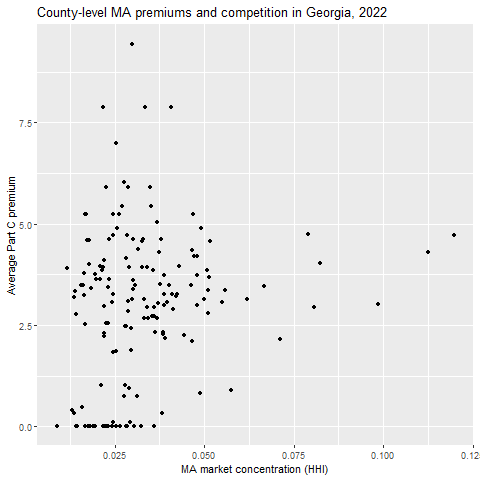

In [39]:
%%R
# 7. Plot average premium vs HHI (R)

ggplot(ga_county_2022, aes(x = hhi_ma, y = avg_premium_partc)) +
  geom_point() +
  labs(
    x = "MA market concentration (HHI)",
    y = "Average Part C premium",
    title = "County-level MA premiums and competition in Georgia, 2022"
  )


In [ ]:
# 7. Plot average premium vs HHI (Python)

plt.scatter(ga_county_2022_py["hhi_ma"], ga_county_2022_py["avg_premium_partc"])
plt.xlabel("MA market concentration (HHI)")
plt.ylabel("Average Part C premium")
plt.title("County-level MA premiums and competition in Georgia, 2022")
plt.show()
